In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from preprocess import pre_process
import xgboost as xgb

In [3]:
def train_xgb(X, y, params):
    x, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

    xg_train = xgb.DMatrix(x, label=y_train)
    xg_val = xgb.DMatrix(X_val, label=y_val)

    watchlist  = [(xg_train,'train'), (xg_val,'eval')]
    return xgb.train(params, xg_train, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=num_rounds/20)

def cv_xgb(X, y, params):
    d_train = xgb.DMatrix(X, label=y)
    cv_result = xgb.cv(params, d_train, num_boost_round=500, nfold=5, 
                       verbose_eval=50, early_stopping_rounds=100)

def predict_xgb(clr, X_test):
    return clr.predict(xgb.DMatrix(X_test))
    
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

In [2]:
train_df, test_df = pre_process()
tfidf = CountVectorizer(stop_words='english', max_features=200)
tr_sparse = tfidf.fit_transform(train_df["features"])
te_sparse = tfidf.transform(test_df["features"])

train_df.head(3)

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,num_rot30_X,num_rot30_Y,num_rot45_X,num_rot45_Y,num_rot60_X,num_rot60_Y,manager_level_low,manager_level_medium,manager_level_high,manager_skill
0,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,,40.7145,7211212,-73.9425,...,-1.711459,-84.393333,-23.495744,-81.074742,-43.678833,-72.231041,1.0,0.0,0.0,0.0
1,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,Doorman Elevator Fitness_Center Cats_Allowed D...,40.7947,7150865,-73.9667,...,-1.654103,-84.454391,-23.456146,-81.148564,-43.659691,-72.312597,NaN,NaN,NaN,NaN
2,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,Laundry_In_Building Dishwasher Hardwood_Floors...,40.7388,6887163,-74.0018,...,-1.720064,-84.456839,-23.520493,-81.133856,-43.718039,-72.281736,NaN,NaN,NaN,NaN


In [17]:
train_X = sparse.hstack([train_df[features_to_use], tr_sparse]).tocsr()
test_X = sparse.hstack([test_df[features_to_use], te_sparse]).tocsr()

target_num_map = {'high':0, 'medium':1, 'low':2}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
print train_X.shape, test_X.shape

(49352, 251) (74659, 251)


[0]	train-mlogloss:1.08528	eval-mlogloss:1.08544
Multiple eval metrics have been passed: 'eval-mlogloss' will be used for early stopping.

Will train until eval-mlogloss hasn't improved in 50 rounds.
[200]	train-mlogloss:0.504119	eval-mlogloss:0.553497
[400]	train-mlogloss:0.435832	eval-mlogloss:0.521937
[600]	train-mlogloss:0.394325	eval-mlogloss:0.512307
[800]	train-mlogloss:0.363472	eval-mlogloss:0.508321
[1000]	train-mlogloss:0.339251	eval-mlogloss:0.506614
[1200]	train-mlogloss:0.319035	eval-mlogloss:0.505781
[1400]	train-mlogloss:0.301924	eval-mlogloss:0.50545
[1600]	train-mlogloss:0.28578	eval-mlogloss:0.504995
Stopping. Best iteration:
[1588]	train-mlogloss:0.286648	eval-mlogloss:0.504934



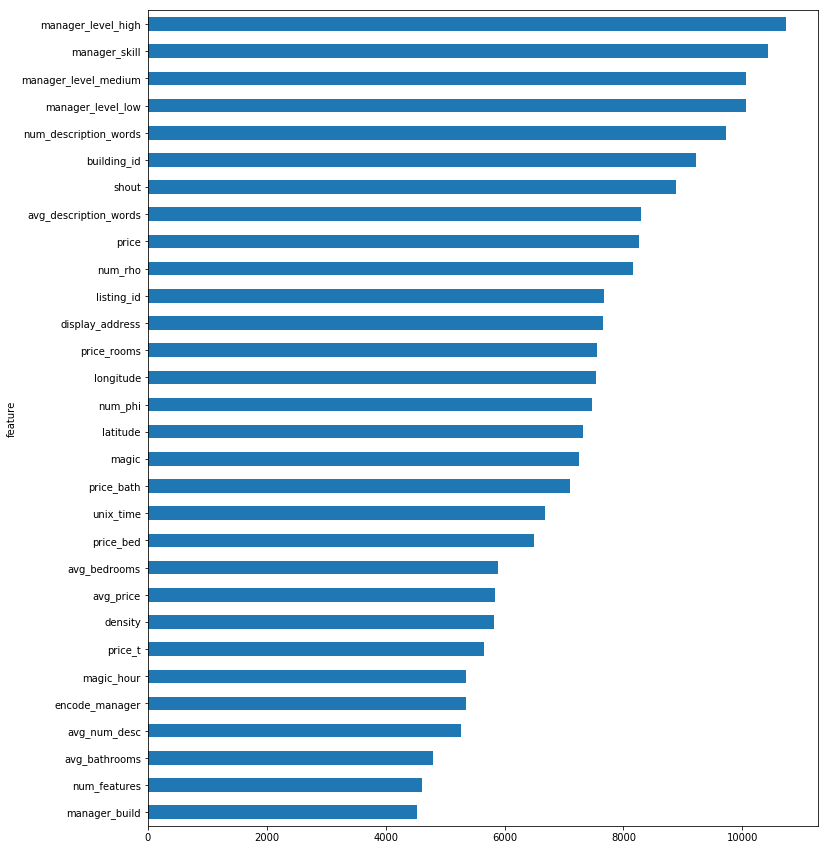

In [ ]:
param = {}
param['objective'] = 'multi:softprob'
param['num_class'] = 3
param['eval_metric'] = "mlogloss"
param['eta'] = 0.02
param['alpha'] = 0
param['max_depth'] = 8
param['colsample_bytree'] = 0.38
param['gamma'] = 0
param['min_child_weight'] = 19.4
param['subsample'] = 0.8
param['silent'] = 1
param['seed'] = 0
num_rounds = 4000

create_feature_map(features_to_use)
clr = train_xgb(train_X, train_y, param)
importance = clr.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1))[-30:]
ft = pd.DataFrame(importance, columns=['feature', 'fscore'])
ft.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(12, 15))

In [ ]:
def train_xgb(X, y, params):
    x, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

    xg_train = xgb.DMatrix(x, label=y_train)
    xg_val = xgb.DMatrix(X_val, label=y_val)

    watchlist  = [(xg_train,'train'), (xg_val,'eval')]
    return xgb.train(params, xg_train, num_rounds, watchlist, early_stopping_rounds=50, verbose_eval=False)

sumPred = np.zeros((test_X.shape[0], 3))
for i in xrange(10):
    print 'Start '+str(i+1)+' times of training'
    clr = train_xgb(train_X, train_y, param)
    sumPred += predict_xgb(clr, test_X)
    print 'Iteration: '+str(clr.best_iteration)+'  Multi-logloss: '+str(clr.best_score)
    
preds = sumPred/10

Start 1 times of training
Iteration: 1439  Multi-logloss: 0.503691
Start 2 times of training
Iteration: 1393  Multi-logloss: 0.501872
Start 3 times of training
Iteration: 1279  Multi-logloss: 0.509638
Start 4 times of training
Iteration: 1378  Multi-logloss: 0.49996
Start 5 times of training
Iteration: 1163  Multi-logloss: 0.517018
Start 6 times of training
Iteration: 1402  Multi-logloss: 0.497055
Start 7 times of training
Iteration: 1204  Multi-logloss: 0.516374
Start 8 times of training
Iteration: 1377  Multi-logloss: 0.502006
Start 9 times of training
Iteration: 1574  Multi-logloss: 0.501095
Start 10 times of training


In [ ]:
out_df = pd.DataFrame(preds)
out_df.columns = ["high", "medium", "low"]
out_df["listing_id"] = test_df.listing_id.values
out_df.to_csv("xgb_f.csv", index=False)